In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [2]:
from PIL import Image
from matplotlib import image, pyplot
import pandas as pd
import numpy as np
import joblib
import cv2
import os
import seaborn as sns
from numpy import asarray
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Input,Activation,add,Concatenate ,Dropout
from tensorflow.keras.models import Sequential, Model
from keras import models
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score, precision_score, f1_score,confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.models import load_model
from tensorflow.keras.models import Sequential
import pickle
from tensorflow.keras.models import save_model

In [3]:
dataset_path = r"C:\Users\Kyla\Downloads\Plant_Disease_Dataset\Plant_Disease_Dataset"

In [4]:
# Image settings
IMG_SIZE = (128,128)
BATCH_SIZE = 64

In [5]:
# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [6]:
# Load training data
train_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 56251 images belonging to 38 classes.


In [7]:
# Load validation data
validation_generator = datagen.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 14044 images belonging to 38 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, 'test', 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 654 images belonging to 38 classes.


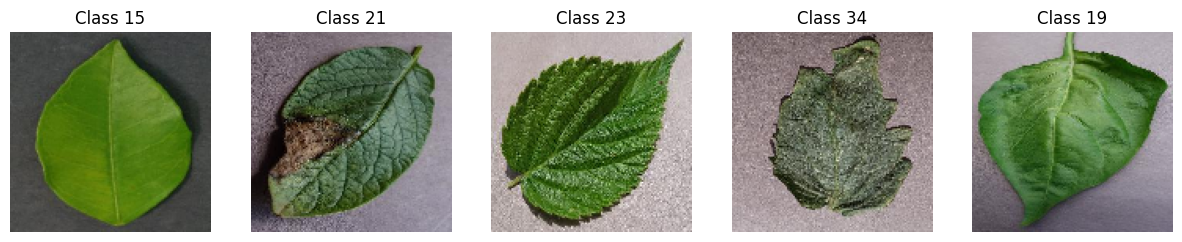

In [9]:
# Fetch a batch of images and labels
X_batch, y_batch = next(train_generator)

# Define the number of images to display
num_images = 5

# Create a figure to display the images
plt.figure(figsize=(15, 5))

for i in range(num_images):
    image = X_batch[i] * 255
    image = image.astype(np.uint8)

    # Create a subplot for each image
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis('off')
    # Display the class label
    plt.title(f"Class {np.argmax(y_batch[i])}")

plt.show()

In [10]:
def define_model(optimization: str, regularization_datatype, early_stopping: bool, dropout: float, learning_rate: float):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(train_generator.num_classes, activation='softmax')
    ])
    model.compile(optimizer= optimization,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [11]:
def evaluate_model(model, test_generator, model_name="Model"):
    print(f"\nEvaluating {model_name}...\n")
    _, test_acc = model.evaluate(test_generator, verbose=0)

    y_pred_prob = model.predict(test_generator)
    y_pred_classes = y_pred_prob.argmax(axis=1)

    # Calculate Confusion Matrix
    cm = confusion_matrix(test_generator.classes, y_pred_classes)

    f1 = f1_score(test_generator.classes, y_pred_classes, average='micro')
    recall = recall_score(test_generator.classes, y_pred_classes, average='micro')
    precision = precision_score(test_generator.classes, y_pred_classes, average='micro')

    print(f'{model_name} - Test Accuracy: {test_acc:.3f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}')

    # Save the model
    joblib.dump(model, f'{model_name}.pkl')
    print(f"Model '{model_name}' saved successfully.")
    print("\nConfusion Matrix:\n", cm)

    # Visualize Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
def loss_curve_plot(model, history, test_generator, model_name="Model"):
    #  Plot Loss Curve
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
    plt.title(f'{model_name} - Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [13]:
# Create and train the first model (Adam)
model_1 = define_model('adam', None, False, 0.0, 0.0)
history_1 = model_1.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=10);




Epoch 1/10


879/879 [==============================] - 1146s 1s/step - loss: 1.3694 - accuracy: 0.6056 - val_loss: 0.7585 - val_accuracy: 0.7580
Epoch 2/10
879/879 [==============================] - 1090s 1s/step - loss: 0.4937 - accuracy: 0.8462 - val_loss: 0.4496 - val_accuracy: 0.8587
Epoch 3/10
879/879 [==============================] - 1116s 1s/step - loss: 0.3078 - accuracy: 0.9015 - val_loss: 0.3701 - val_accuracy: 0.8833
Epoch 4/10
879/879 [==============================] - 789s 897ms/step - loss: 0.2082 - accuracy: 0.9326 - val_loss: 0.3573 - val_accuracy: 0.8933
Epoch 5/10
879/879 [==============================] - 790s 898ms/step - loss: 0.1597 - accuracy: 0.9471 - val_loss: 0.3145 - val_accuracy: 0.9064
Epoch 6/10
879/879 [==============================] - 761s 866ms/step - loss: 0.1196 - accuracy: 0.9598 - val_loss: 0.4245 - val_accuracy: 0.8835
Epoch 7/10
879/879 [==============================] - 719s 818ms/step - loss: 0.1005 - accuracy: 0.9656 - val_loss: 0.3900 - 


Evaluating Model1...

11/11 [==============================] - 2s 196ms/step
Model1 - Test Accuracy: 0.920, F1 Score: 0.5092, Recall: 0.5092, Precision: 0.5092
Model 'Model1' saved successfully.

Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


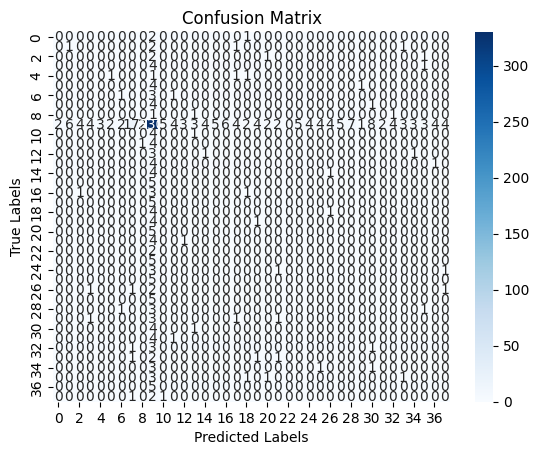

In [14]:
evaluate_model(model_1, test_generator, model_name="Model1") 

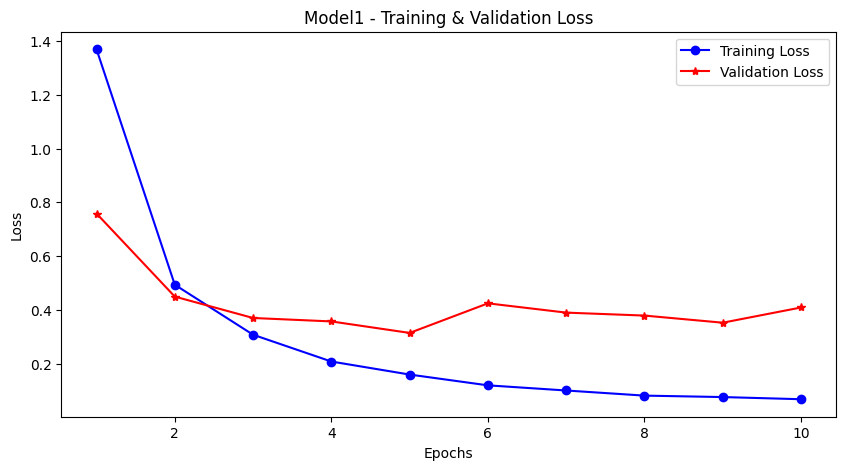

In [15]:
# Plot loss curve & evaluate
loss_curve_plot(model_1, history_1, test_generator, model_name="Model1")

In [17]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [18]:
model_1.save("Model.keras")

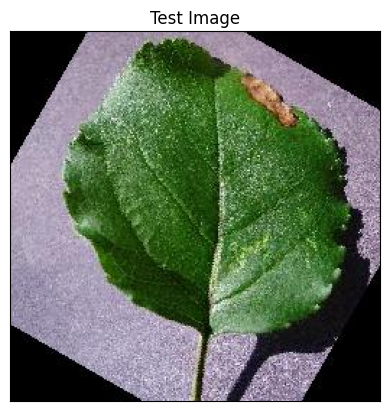

(1, 128, 128, 3)
1/1 [==============================] - 0s 106ms/step
Predicted class index: 1
Predicted Disease: Apple___Black_rot


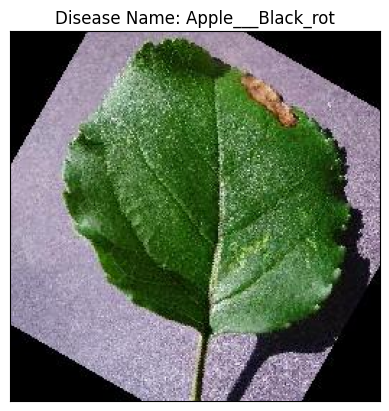

In [26]:
model = tf.keras.models.load_model(r"C:\Users\Kyla\Downloads\Model (1).keras")

image_path = r"C:\Users\Kyla\Downloads\Plant_Disease_Dataset\Plant_Disease_Dataset\test\test\Apple___Black_rot\0b37761a-de32-47ee-a3a4-e138b97ef542___JR_FrgE.S 2908_new30degFlipLR.JPG"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Test Image")
plt.xticks([])
plt.yticks([])
plt.show()

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0)
input_arr = input_arr / 255.0

print(input_arr.shape)


prediction = model.predict(input_arr)
prediction, prediction.shape

result_index = np.argmax(prediction)
print(f"Predicted class index: {result_index}")

class_name = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___healthy',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___healthy',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___healthy',
    'Potato___Late_blight',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___healthy',
    'Strawberry___Leaf_scorch',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

model_prediction = class_name[result_index]
print(f"Predicted Disease: {model_prediction}")

plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()